#  Прогнозирование заказов такси

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

## Цель проекта

Необходимо построить модель, предсказывающую количество заказов такси на следующий час. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## План работы

1. Загрузка данных.
2. Ресемплирование данных по одному часу.
3. Исслдование данных.
4. Подготовка данных к машинному обучению.
5. Обучение моделей.
6. Тестирование лучшей модели.

## Описание данных

- **datetime** - время;
- **num_orders** - количество заказов.

## Настройка окружения

### Загрузка библиотек

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
import numpy as np
import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

### Функции

In [2]:
# функция отрисовки графиков
def graph_plot(data, graph_size, graph_title, graph_x, graph_y, graph_legend):
    plt.figure(figsize=graph_size)
    plt.plot(data)
    plt.title(graph_title)
    plt.legend(graph_legend)
    plt.xlabel(graph_x)
    plt.ylabel(graph_y)
    plt.show()

## Загрузка и подготовка данных

In [3]:
# загрузим данные и переведем даты в индексы, спарсив дату
path_1 = '/datasets/taxi.csv'
path_2 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(path_1):
    data = pd.read_csv(path_1, index_col=[0], parse_dates=[0])
elif os.path.exists(path_2):
    data = pd.read_csv(path_2, index_col=[0], parse_dates=[0])
else:
    print('Что то пошло не так')

In [4]:
# проверим
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# посмотрим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Дата распозналась, перевели в индексы, пропусков нет. Каждая строка содержит данные по количеству заказов такси в аэропорты за 10 минут.

In [6]:
# проверим дубликаты
data.index.duplicated().sum()

0

Дубликаты отсутствуют.

In [7]:
# установим индекс в хронологическом порядке
data = data.sort_index()
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Перед нами данные за период с марта по август 2018 г.

In [8]:
# проверим данные на монотонность
data.index.is_monotonic

True

Данные монотонны.

In [9]:
# заказчика интересует часовой интервал планирования, поэтому ресемплируем данные в данном масштабе и проверими
data = data.resample('1H').sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Ресемплирование прошло успешно

По результатам проведенного этапа, можно сделать следующие выводы:
- данные загрузились успешно;
- столбец с датами был спарсен по типу данных 'дата' и переведен в индексы;
- в первоначальном датафрейме каждая строка представляет информацию о количестве заказов такси в аэропорты за 10 минут;
- в первоначальном датафрейме содержится 26496 строк;
- данные представлены за период с марта по август 2018 г.;
- явные дубликаты в данных отсутствуют;
- данные монотонны;
- для решения задачи заказчика датафрейм был ресемплирован в масштаб 1 часа, новый датафрейм содержит 4416 строк.

## Анализ

### Общий анализ

In [10]:
# посмотри общие статистические данные
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Общая статистика за весь период предоставленных наблюдений говорит следующее: среднее количество заказов в час 84, минимльное 0, максимальное 462.

In [11]:
# создадим признак скользящего среднего по дням и неделям 
data['rolling_mean_day'] = data.rolling(24).mean().shift(1)

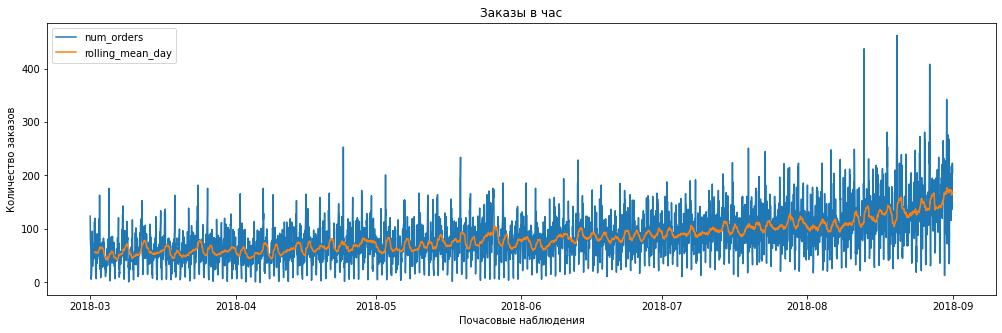

In [12]:
# Визуализируем данные
graph_plot(data, (17, 5), 'Заказы в час', 'Почасовые наблюдения', 'Количество заказов', list(data.columns))

В первом приближении можно сказать, что в среднем количество заказов росло, за предоставленный период.

### Анализ декомпозиций

In [13]:
# декомпозируем данные по всему периоду
decomposed = seasonal_decompose(data['num_orders'])

# ресемплим по дню и декомпозируем
data_w = data.resample('1D').sum()
decomposed_w = seasonal_decompose(data_w['num_orders'])

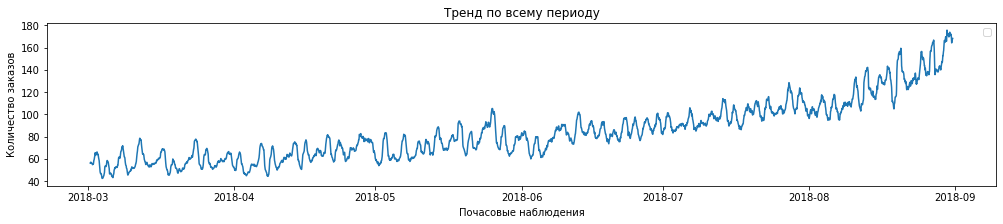

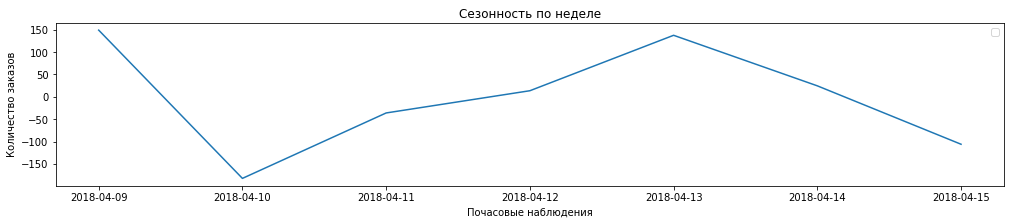

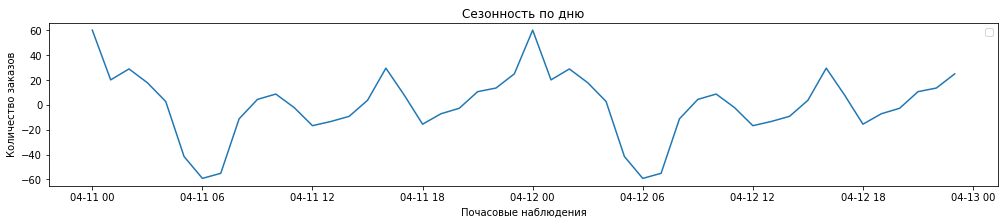

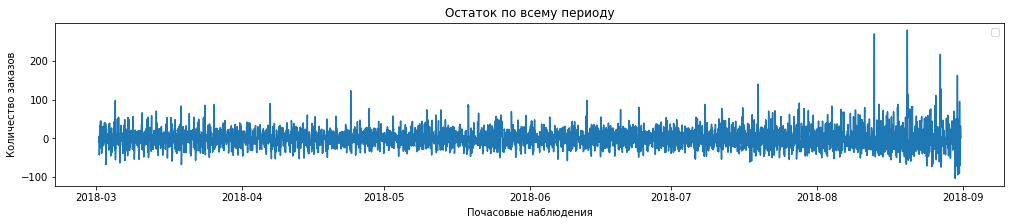

In [14]:
# визуализируем
graph_plot(decomposed.trend, (17, 3), 'Тренд по всему периоду', 'Почасовые наблюдения', 'Количество заказов', '')
graph_plot(decomposed_w.seasonal['2018-04-09':'2018-04-15'], (17, 3), 'Сезонность по неделе', 'Почасовые наблюдения', 'Количество заказов', '')
graph_plot(decomposed.seasonal['2018-04-11 00:00:00':'2018-04-12 23:00:00'], (17, 3), 'Сезонность по дню', 'Почасовые наблюдения', 'Количество заказов', '')
graph_plot(decomposed.resid, (17, 3), 'Остаток по всему периоду', 'Почасовые наблюдения', 'Количество заказов', '')

По первому графику видно, что в среднем имеем растущий тренд. Наиболее активно тенденция к росту наблюдается с июня. Стоит ли за этим реальный рост бизнеса компании в целом, или мы наблюдаем эффект отпусков(большое количество перелетов = более частое использование такси до аэропортов), сказать сложно, так как мы не имеем данные за полный год. Наблюдается недельная сезонность: высокое количество заказов в понедельник, минимум заказов во вторник, плавный рост заказов со среды по четверг, максимум заказов в пятницу,  и спад заказов до второго минимума в воскресенье. Наблюдается сезонность в течние дня: Можно сделать вывод, что максимум заказов наблюдается в интервале с 22:00 до 3:00 и с 08:00 до 11:00, минимум с 05:00 до 07:00.

### Оценка стационарности 

Так как для эффективного моделирования важна характеристика стационарности временного ряда, и решение вопроса о дполнительных преобразованиях перед обучением, то проведем оценку на стационарность.

Проведем статистический тест **Дикки-Фуллера**. Нулевая гипотеза: ряд нестационарен. Алтернативная гипотеза: ряд стационарен. Уровень статистической значимости - 5%.

In [15]:
# тест Дикки-Фуллера
test_adf = adfuller(data['num_orders'])
print(f'p-value: {test_adf[1]}')

p-value: 0.028940051402612906


По результатам проведенного теста можно сказать, что нулевая гипотеза о нестационарности нашего временного ряда отвергнута. С уровнем статистической значимости в 5%, можно утверждать, что ряд стационарен. Срабатывание данного теста ложное, так были идентефицированы и тренд и сезонность, но для нашего инструментария стационарность не является принципиальным моментом.

### Оценка разностей

In [16]:
# создадим три поля разности
data['difference_first'] = data['num_orders'] - data['num_orders'].shift(1).fillna(0)
data['difference_second'] = data['difference_first'] - data['difference_first'].shift().fillna(0)
data['difference_third'] = data['difference_second'] - data['difference_second'].shift().fillna(0)

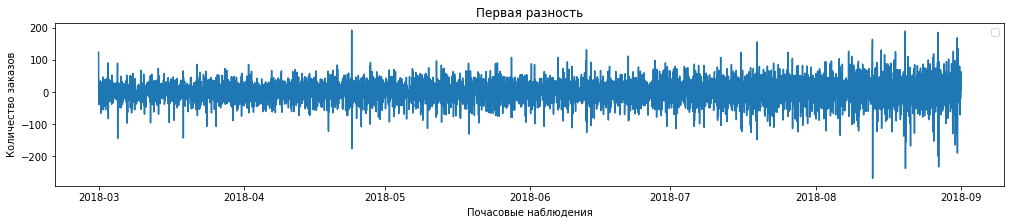

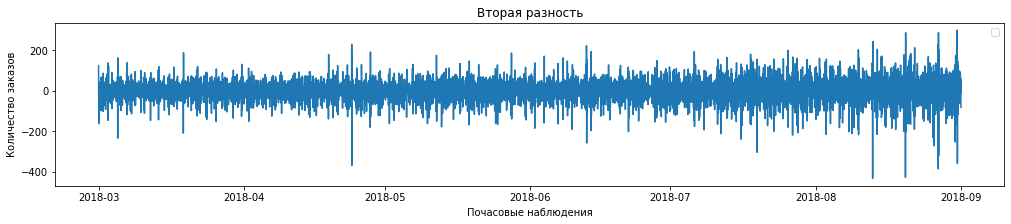

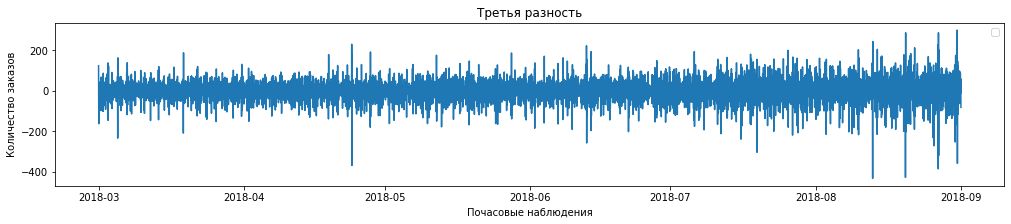

In [17]:
graph_plot(data['difference_first'], (17, 3), 'Первая разность', 'Почасовые наблюдения', 'Количество заказов', '')
graph_plot(data['difference_second'], (17, 3), 'Вторая разность', 'Почасовые наблюдения', 'Количество заказов', '')
graph_plot(data['difference_second'], (17, 3), 'Третья разность', 'Почасовые наблюдения', 'Количество заказов', '')

Хотя и общеизвестно, что разности временного ряда более стационарны чем сам ряд, но проведем тест на стационарность. Нулевая гипотеза: ряд нестационарен. Алтернативная гипотеза: ряд стационарен. Уровень статистической значимости - 5%. 

In [18]:
for column in ('difference_first', 'difference_second', 'difference_third'):
    test_adf = adfuller(data[column])
    print(f'p-value {column}: {test_adf[1]}')

p-value difference_first: 1.0915609954407956e-28
p-value difference_second: 0.0
p-value difference_third: 0.0


По результатам проведенного теста можно сказать, что нулевая гипотеза о нестационарности наших рядов отвергнута. С уровнем статистической значимости в 5%, можно утверждать, что ряды стационарны. Срабатывание данного теста ложное, так были идентефицированы и тренд и сезонность, но для нашего инструментария стационарность не является принципиальным моментом.

### Анализ выбросов

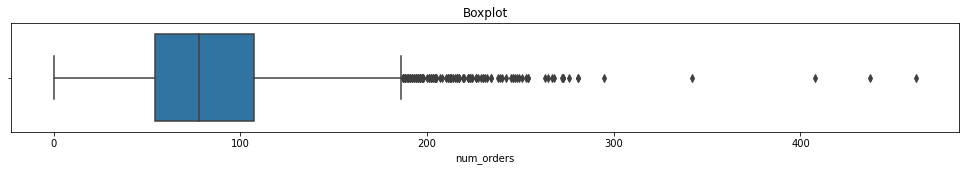

In [19]:
# посмотрим выбросы в боксплоте
plt.figure(figsize=(17, 2))
sns.boxplot(data = data[['num_orders']], x='num_orders')
plt.title('Boxplot')
plt.show()

In [20]:
# вычислим межквантильное расстояние
q3, q1 = np.percentile (data['num_orders'], [75 ,25])
iqr = q3 - q1
iqr, q3

(53.0, 107.0)

In [21]:
# найдем край правого уса
q_moustache = q3 + 1.5*iqr
q_moustache

186.5

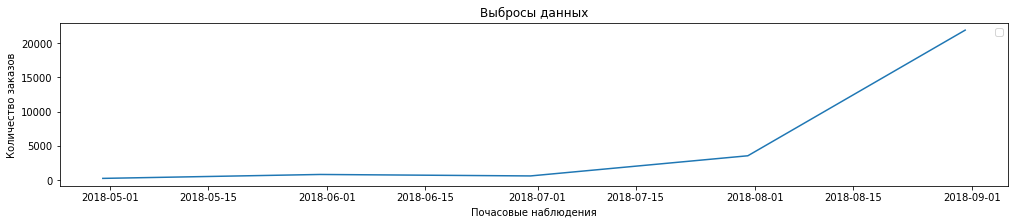

In [22]:
# изучим выбросы
data_outliers = data[data['num_orders'] > q_moustache]
graph_plot(data_outliers['num_orders'].resample('1M').sum(), (17, 3), 'Выбросы данных',\
           'Почасовые наблюдения', 'Количество заказов', '')

Как можно заметить, основное количество выбросов сосредоточено в области общего повышательного тренда временного ряда. А именно в июле-августе, что вполне укладывается в концепцию повышенного спроса на такси в аэропорты в период отпусков. Поэтому будем считать, что эти выбросы органичны, откажемся от их удаления.

Таким образом по проделанному этапу работы можно сказать следующее:
  - количество заказов такси в аэропорты в среднем имеем растущий тренд, по всему периоду данных. Наиболее активно тенденция к росту наблюдается с июня. Стоит ли за этим реальный рост бизнеса компании в целом, или мы наблюдаем эффект отпусков(большое количество перелетов = более частое использование такси до аэропортов), сказать сложно, так как мы не имеем данные за полный год;
  - в рамках недели можно сезонность: высокое количество заказов в понедельник, минимум заказов во вторник, плавный рост заказов со среды по четверг, максимум заказов в пятницу,  и спад заказов до второго минимума в воскресенье;
  - в рамках недели можно сезонность: видно что количетво заказов колеблется в течение дня с постоянной переодичностью и амплитудой, максимум заказов наблюдается в интервале с 22:00 до 3:00 и с 08:00 до 11:00, минимум с 05:00 до 07:00;
  - статистический тест Дикки-Фуллера показывает, что с уровнем статистической значимости в 5%, можно утверждать, что  стационарны следующие ряды: изначальный временной ряд, первая, вторая и третья разности. Срабатывание данного теста ложное, так были идентефицированы и тренд и сезонность, но для нашего инструментария стационарность не является принципиальным моментом.
  - выбросы данных сосредоточены в области общего повышательного тренда временного ряда. А именно в июле-августе, что вполне укладывается в концепцию повышенного спроса на такси в аэропорты в период отпусков. Поэтому будем считать, что эти выбросы органичны, откажемся от их удаления.
  
--------------------------------------------------------------------------------------------------------------------------------
На основании вышеприведенных выводов, можно сказать, что при обучении модели нам нужно учесть такие признаки как: месяц, день, день недели и час; разности и скользящее среднее. Признак года не понадобится.



## Обучение

### Создание признаков

In [23]:
# создадим календарные признаки, остальные мы уже создали на предыдущем этапе
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [23]:
# создадим календарные признаки, остальные мы уже создали на предыдущем этапе
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [24]:
# удалим пропущенные значения и столбцы разностей
data = data.drop(['difference_first', 'difference_second', 'difference_third'], axis=1)
data['max_lag'] = data['num_orders'].shift(24)
data = data.dropna()
data

,num_orders,rolling_mean_day,dayofweek,hour,max_lag
datetime,,,,,
2018-03-02 00:00:00,90,56.833333,4,0,124.0
2018-03-02 01:00:00,120,55.416667,4,1,85.0
2018-03-02 02:00:00,75,56.875000,4,2,71.0
2018-03-02 03:00:00,64,57.041667,4,3,66.0
2018-03-02 04:00:00,20,56.958333,4,4,43.0
...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,4,19,72.0
2018-08-31 20:00:00,154,167.541667,4,20,142.0
2018-08-31 21:00:00,159,168.041667,4,21,198.0


### Создание выборок

In [25]:
# скопируем датафрейм и дропнем индексы
df = data.copy()
df.reset_index(drop= True , inplace= True)
df

,num_orders,rolling_mean_day,dayofweek,hour,max_lag
0,90,56.833333,4,0,124.0
1,120,55.416667,4,1,85.0
2,75,56.875000,4,2,71.0
3,64,57.041667,4,3,66.0
4,20,56.958333,4,4,43.0
...,...,...,...,...,...
4387,136,164.875000,4,19,72.0
4388,154,167.541667,4,20,142.0
4389,159,168.041667,4,21,198.0
4390,223,166.416667,4,22,158.0


In [26]:
# разделим признаки
target = df['num_orders']
features = df.drop(['num_orders'], axis=1)
print(target.shape, features.shape)

(4392,) (4392, 4)


In [27]:
# создадим выборки, не забыв про отключение перемешивания
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1
)

print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(3952, 4) (440, 4)
(3952,) (440,)


### Линейная регрессия

In [28]:
# определим списки столбцов по типам
cat_columns = [ 'dayofweek', 'hour'] # категориальные столбцы 
num_columns = ['rolling_mean_day',  'max_lag'] # числовые столбцы 

In [29]:
# скопируем признаки для OHE кодирования
features_train_ohe = features_train.copy() 
features_test_ohe = features_test.copy()

In [30]:
# проведем OHE кодирование категориальных признаков на трейне
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
encoder_ohe.fit(features_train_ohe[cat_columns])
features_train_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_train_ohe[cat_columns])
features_train_ohe = features_train_ohe.drop(cat_columns, axis=1)

# проведем OHE кодирование категориальных признаков на тесте
features_test_ohe[encoder_ohe.get_feature_names()] = encoder_ohe.transform(features_test_ohe[cat_columns])
features_test_ohe = features_test_ohe.drop(cat_columns, axis=1)

In [31]:
# масштабируем числовые признаки на трейне
scaler = StandardScaler()
scaler.fit(features_train_ohe[num_columns])
features_train_ohe[num_columns] = scaler.transform(features_train_ohe[num_columns])

# масщтабируем числовые признаки на тесте
features_test_ohe[num_columns] = scaler.transform(features_test_ohe[num_columns])

In [32]:
# сравним размерности полученных выборок
print(features_train_ohe.shape, features_test_ohe.shape)

(3952, 31) (440, 31)


In [33]:
# пустой словар для кросс-валидации
param_lr = {}
# инициализируем модель и подбор параметров
model_lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
tuning_model_lr=GridSearchCV(estimator=model_lr,
                          param_grid=param_lr,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv)

# приступим к обучению с определением лучших параметров и RSME
tuning_model_lr.fit(features_train_ohe, target_train)
rmse_lr = tuning_model_lr.best_score_*-1
print(rmse_lr)

26.10439598152474


### Модель DecisionTreeRegressor

In [34]:
# зададим список варьируемых параметров
param_dt= { 
            "splitter":("best", "random"), 
            "max_depth":(list(range(1, 20, 2))), 
            "min_samples_split":[2, 3, 4], 
            "min_samples_leaf":list(range(1, 20, 2)), 
           }
    

# инициализируем модель, кросс-валидацию и подбор параметров
model_dt = DecisionTreeRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=5)
tuning_model_dt=GridSearchCV(estimator=model_dt,
                          param_grid=param_dt,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv)

# приступим к обучению с определением лучших параметров и RSME
tuning_model_dt.fit(features_train, target_train)
best_model_dt = tuning_model_dt.best_params_
display(best_model_dt)
rmse_dt = tuning_model_dt.best_score_*-1
print(rmse_dt)

{'max_depth': 9,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'splitter': 'best'}

27.65836187954651


### Модель LGBMRegressor

In [35]:
# зададим список варьируемых параметров
param_grid = {'n_estimators': [100, 500], 'num_leaves': [n for n in range(20, 30, 5)]}

# инициализируем модель, кросс-валидацию и подбор параметров
model_gb = lgb.LGBMRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=5)
tuning_model_gb=GridSearchCV(estimator=model_gb,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv)

# приступим к обучению с определением лучших параметров и RSME
tuning_model_gb.fit(features_train, target_train)
best_model_gb = tuning_model_gb.best_params_
display(tuning_model_gb.best_params_)
rsme_gb = tuning_model_gb.best_score_*-1
print(rsme_gb)

{'n_estimators': 100, 'num_leaves': 20}

24.845360569806566


### Модель RandomForestRegressor

In [36]:
# зададим список варьируемых параметров
param_grid = {
              'max_depth':[x for x in range(2,5,1)], 
              'n_estimators':[x for x in range(10,31,5)]
             }

# инициализируем модель, кросс-валидацию и подбор параметров
model_rf = RandomForestRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=5)
tuning_model_rf=GridSearchCV(estimator=model_dt,
                          param_grid=param_dt,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv)

# приступим к обучению с определением лучших параметров и RSME
tuning_model_rf.fit(features_train, target_train)
best_model_rf = tuning_model_rf.best_params_
display(best_model_rf)
rmse_rf = tuning_model_rf.best_score_*-1
print(rmse_rf)

{'max_depth': 9,
 'min_samples_leaf': 17,
 'min_samples_split': 2,
 'splitter': 'best'}

27.65836187954651


### Сводные данные по моделям

In [37]:
# сформируем сводную таблицу с результатми
result = pd.DataFrame(
                      [[rmse_lr, rmse_dt, rsme_gb, rmse_rf]],
                      index=['Результаты RMSE на кросс-валидации'],
                      columns=['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor', 'RandomForestRegressor']
)
result

,LinearRegression,DecisionTreeRegressor,LGBMRegressor,RandomForestRegressor
Результаты RMSE на кросс-валидации,26.104396,27.658362,24.845361,27.658362


Таким образом, наилучшее RMSE = 24.845361  на кросс-валидации показала модель LGBMRegressor. Тестирование будем проводить на данной модели. Лучшие параметры модели: {'n_estimators': 100, 'num_leaves': 20}

## Тестирование

In [38]:
# обучим модель на лучших параметрах
model_gb = lgb.LGBMRegressor(random_state=12345, **best_model_gb)
model_gb.fit(features_train, target_train)

LGBMRegressor(num_leaves=20, random_state=12345)

In [39]:
# проверим лучшую модель на тестовой выборке
target_predict = model_gb.predict(features_test)

# определим метрику качества 
final_RMSE = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE

44.96848453697146

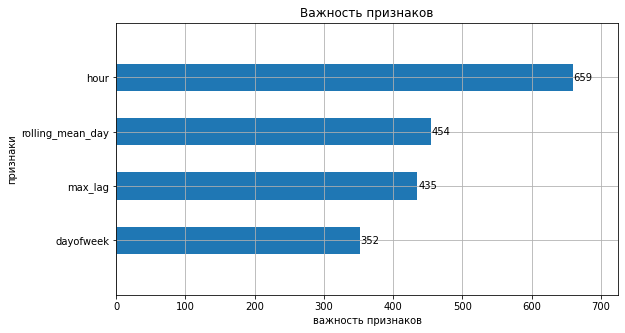

In [40]:
# посмотрим на то, какие признаки влияют больше всего
lgb.plot_importance(model_gb, height=.5, xlabel ='важность признаков', ylabel ='признаки', title='Важность признаков',\
                    figsize=(9,5));

Наиболее значимым признаком является час, в который вызывают такси до аэропорта.

In [41]:
# проверим модель на адекватность
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
DummyRegressor()
dummy_regr_predict = dummy_regr.predict(features_test)
rmse = mean_squared_error(target_test,dummy_regr_predict)**0.5
print('Среднеквадратическая ошибка для модели Дамми составляет:', rmse)

Среднеквадратическая ошибка для модели Дамми составляет: 84.68768287118466


Модель адекватна.

## Итоговый вывод

**По результатам проделанной работы, можно сказать следующее:**

--------------------------------------------------------------------------------------------------------------------------------
По результатам загрузки и подготовки данных, можно сделать следующие выводы:
- данные загрузились успешно;
- столбец с датами был спарсен по типу данных 'дата' и переведен в индексы;
- в первоначальном датафрейме каждая строка представляет информацию о количестве заказов такси в аэропорты за 10 минут;
- в первоначальном датафрейме содержится 26496 строк;
- данные представлены за период с марта по август 2018 г.;
- явные дубликаты в данных отсутствуют;
- данные монотонны;
- для решения задачи заказчика датафрейм был ресемплирован в масштаб 1 часа, новый датафрейм содержит 4416 строк.
--------------------------------------------------------------------------------------------------------------------------------
По результатам анализа данных, можно сделать следующие выводы:
  - количество заказов такси в аэропорты в среднем имеем растущий тренд, по всему периоду данных. Наиболее активно тенденция к росту наблюдается с июня. Стоит ли за этим реальный рост бизнеса компании в целом, или мы наблюдаем эффект отпусков(большое количество перелетов = более частое использование такси до аэропортов), сказать сложно, так как мы не имеем данные за полный год;
  - в рамках недели можно сезонность: высокое количество заказов в понедельник, минимум заказов во вторник, плавный рост заказов со среды по четверг, максимум заказов в пятницу,  и спад заказов до второго минимума в воскресенье;
  - в рамках недели можно сезонность: видно что количетво заказов колеблется в течение дня с постоянной переодичностью и амплитудой, максимум заказов наблюдается в интервале с 22:00 до 3:00 и с 08:00 до 11:00, минимум с 05:00 до 07:00;
  - статистический тест Дикки-Фуллера показывает, что с уровнем статистической значимости в 5%, можно утверждать, что  стационарны следующие ряды: изначальный временной ряд, первая, вторая и третья разности. Срабатывание данного теста ложное, так были идентефицированы и тренд и сезонность, но для нашего инструментария стационарность не является принципиальным моментом.
  - выбросы данных сосредоточены в области общего повышательного тренда временного ряда. А именно в июле-августе, что вполне укладывается в концепцию повышенного спроса на такси в аэропорты в период отпусков. Поэтому будем считать, что эти выбросы органичны, откажемся от их удаления.
  
--------------------------------------------------------------------------------------------------------------------------------
На основании вышеприведенных выводов, можно сказать, что при обучении модели нам нужно учесть такие признаки как: месяц, день, день недели и час; разности и скользящее среднее. Признак года не понадобится.

  
На основании вышеприведенных выводов, можно сказать, что при обучении модели нам нужно учесть такие признаки как: день недели и час;отствание и скользящее среднее за 24 часа.

--------------------------------------------------------------------------------------------------------------------------------
На этапе обучения модели были подготовлены выборки, добавлены признаки. Обучение с подбором гиперпараметров и кросс-валидацией проводилось на следующих моделях:'LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor', 'RandomForestRegressor'. Наилучшее RMSE = 24.845361 на кросс-валидации показала модель LGBMRegressor.

--------------------------------------------------------------------------------------------------------------------------------
Тестирование, обученной на лучших параметрах, модели LGBMRegressor на тестовой выборке показало RMSE =44.96848453697146 , что укладывается в требования заказчика. Лучшие параметры модели: {'n_estimators': 100, 'num_leaves': 20}.

--------------------------------------------------------------------------------------------------------------------------------
**По резултатам проведенной работы для целей заказчика можно порекомендовать модель LGBMRegressor с параметрами {'n_estimators': 100, 'num_leaves': 20}** 